In [1]:
from nselib import capital_market
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader as data
import tensorflow as tf

In [2]:
from_date_str = '01-01-2016'
to_date_str = '01-08-2024'

index_data = capital_market.index_data(index='Nifty 50', from_date=from_date_str, to_date=to_date_str)
index_data['TIMESTAMP'] = pd.to_datetime(index_data['TIMESTAMP'], format='%d-%m-%Y')
index_data = index_data.sort_values('TIMESTAMP').reset_index(drop=True)
index_data

,TIMESTAMP,INDEX_NAME,OPEN_INDEX_VAL,HIGH_INDEX_VAL,CLOSE_INDEX_VAL,LOW_INDEX_VAL,TRADED_QTY,TURN_OVER
0,2016-01-01,NIFTY 50,7938.45,7972.55,7963.20,7909.80,64843836,2613.91
1,2016-01-04,NIFTY 50,7924.55,7937.55,7791.30,7781.10,138864905,5897.08
2,2016-01-05,NIFTY 50,7828.40,7831.20,7784.65,7763.25,149672973,5948.51
3,2016-01-06,NIFTY 50,7788.05,7800.95,7741.00,7721.20,151715828,6722.17
4,2016-01-07,NIFTY 50,7673.35,7674.95,7568.30,7556.60,194732861,7803.21
...,...,...,...,...,...,...,...,...
2128,2024-07-26,NIFTY 50,24423.35,24861.15,24834.85,24410.90,383826136,42118.36
2129,2024-07-29,NIFTY 50,24943.30,24999.75,24836.10,24774.60,354966070,37102.92
2130,2024-07-30,NIFTY 50,24839.40,24971.75,24857.30,24798.65,384989431,37576.58
2131,2024-07-31,NIFTY 50,24886.70,24984.60,24951.15,24856.50,333646302,35411.32


In [3]:
moving_avg_200 = index_data.CLOSE_INDEX_VAL.rolling(200).mean()
moving_avg_100 = index_data.CLOSE_INDEX_VAL.rolling(100).mean()

#covid ema
moving_avg_500 = index_data.CLOSE_INDEX_VAL.rolling(500).mean()

<function matplotlib.pyplot.show(close=None, block=None)>

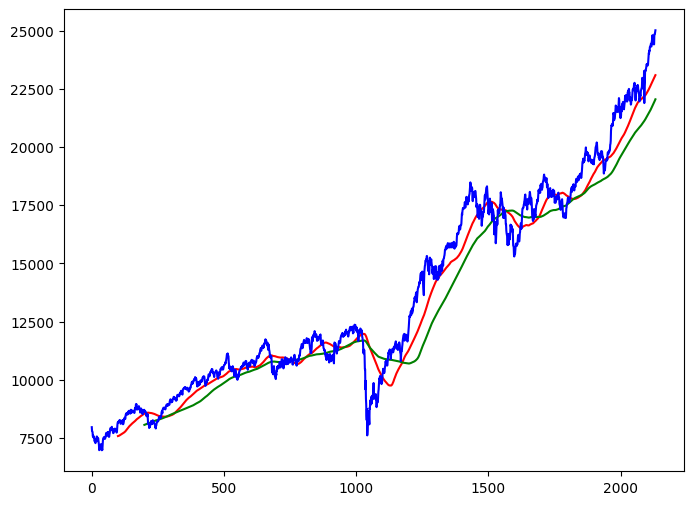

In [4]:
plt.figure(figsize=(8,6))
plt.plot(moving_avg_100,'r')
plt.plot(moving_avg_200,'g')
plt.plot(index_data.CLOSE_INDEX_VAL,'b')
plt.show

In [5]:
df = index_data

data_training = pd.DataFrame(df['CLOSE_INDEX_VAL'][0:int(len(df)*0.70)])
data_testing = pd.DataFrame(df['CLOSE_INDEX_VAL'][int(len(df)*0.70):int(len(df))])

print(data_training.shape)
print(data_testing.shape)

(1493, 1)
(640, 1)


In [6]:
data_training.head()

,CLOSE_INDEX_VAL
0,7963.20
1,7791.30
2,7784.65
3,7741.00
4,7568.30


In [7]:
data_testing.head()

,CLOSE_INDEX_VAL
1493,18257.80
1494,18255.75
1495,18308.10
1496,18113.05
1497,17938.40


In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [9]:
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.08626466],
       [0.07132521],
       [0.07074728],
       ...,
       [0.95882744],
       [0.96338575],
       [0.97699551]])

In [10]:
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100:i])
    y_train.append(data_training_array[i,0])

x_train , y_train = np.array(x_train),np.array(y_train)

In [11]:
from keras.layers import Dense , Dropout , LSTM
from keras.models import Sequential

In [12]:
model = Sequential()
model.add(LSTM(units = 50,activation = 'relu', return_sequences = True,
               input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60,activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80,activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120,activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

C:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 60)             │          26,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 60)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 80)             │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 120)                 │          96,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer='adam' , loss = 'mean_squared_error')
model.fit(x_train,y_train, epochs = 50)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step - loss: 0.0867
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 263ms/step - loss: 0.0095
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - loss: 0.0082
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 271ms/step - loss: 0.0077
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 270ms/step - loss: 0.0068
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 253ms/step - loss: 0.0059
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 268ms/step - loss: 0.0060
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 264ms/step - loss: 0.0064
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - loss: 0.0056
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - loss: 0.0048
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 262ms/step - loss: 0.0051
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 267ms/step - loss: 0.0054
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 260ms/step - loss: 0.0046
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - loss: 0.0055
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 

In [15]:
model.save('keras_model.h5')

In [16]:
data_testing.head()

,CLOSE_INDEX_VAL
1493,18257.80
1494,18255.75
1495,18308.10
1496,18113.05
1497,17938.40


In [17]:
data_training.tail(100)

,CLOSE_INDEX_VAL
1393,16450.50
1394,16496.45
1395,16624.60
1396,16634.65
1397,16636.90
...,...
1488,17745.90
1489,17812.70
1490,18003.30
1491,18055.75


In [18]:
past_100_days = data_training.tail(100)

In [19]:
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)

In [20]:
final_df.head()

,CLOSE_INDEX_VAL
0,16450.50
1,16496.45
2,16624.60
3,16634.65
4,16636.90


In [21]:
input_data = scaler.fit_transform(final_df)
input_data

array([[0.11906477],
       [0.1237934 ],
       [0.13698109],
       [0.13801531],
       [0.13824686],
       [0.14527549],
       [0.1685173 ],
       [0.18921728],
       [0.18345957],
       [0.19970877],
       [0.20891391],
       [0.21449153],
       [0.21287587],
       [0.21199086],
       [0.21361167],
       [0.2121761 ],
       [0.21471793],
       [0.22906848],
       [0.24039352],
       [0.23582954],
       [0.21645708],
       [0.23344722],
       [0.23186758],
       [0.26030111],
       [0.26341408],
       [0.26360961],
       [0.25264989],
       [0.24881141],
       [0.23922551],
       [0.23036512],
       [0.2467481 ],
       [0.26023422],
       [0.24209151],
       [0.2569463 ],
       [0.26773623],
       [0.27295882],
       [0.27769259],
       [0.2951664 ],
       [0.31336057],
       [0.32761335],
       [0.32161381],
       [0.30595633],
       [0.29684895],
       [0.29034515],
       [0.29142569],
       [0.30614156],
       [0.30022949],
       [0.263

In [22]:
input_data.shape

(740, 1)

In [23]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100: i])
    y_test.append(input_data[i,0])

In [24]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(640, 100, 1)
(640,)


In [25]:
# making prediction

y_predicted = model.predict(x_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step


In [26]:
y_predicted.shape

(640, 1)

In [27]:
y_test

array([0.30505073, 0.30483977, 0.31022702, 0.29015477, 0.27218186,
       0.25351431, 0.2391226 , 0.19095643, 0.20421615, 0.18694815,
       0.18610431, 0.21058617, 0.2349754 , 0.2558812 , 0.23326198,
       0.22874431, 0.19759401, 0.20306358, 0.22334163, 0.23795974,
       0.21417766, 0.15943565, 0.21188281, 0.20876984, 0.20695865,
       0.20404635, 0.19687879, 0.18510095, 0.18212176, 0.09822072,
       0.14045938, 0.15440344, 0.13506185, 0.12395805, 0.09795316,
       0.05862165, 0.07408875, 0.10824397, 0.13392471, 0.1375831 ,
       0.16236853, 0.14093276, 0.17307613, 0.20515261, 0.18771482,
       0.20808035, 0.20089221, 0.19853562, 0.19135777, 0.19845844,
       0.20908885, 0.22688682, 0.2234394 , 0.24460761, 0.2840163 ,
       0.27413711, 0.25872661, 0.24142775, 0.25632885, 0.2450707 ,
       0.23018503, 0.2245611 , 0.19348282, 0.17135756, 0.18966493,
       0.21601457, 0.19330788, 0.1708739 , 0.19627678, 0.17956449,
       0.20083047, 0.18616605, 0.18272377, 0.14243522, 0.14295

In [28]:
y_predicted

array([[0.2540752 ],
       [0.25825933],
       [0.263322  ],
       [0.268969  ],
       [0.27490208],
       [0.28087825],
       [0.28642842],
       [0.29080263],
       [0.2931715 ],
       [0.2933027 ],
       [0.29140273],
       [0.28775027],
       [0.2828561 ],
       [0.277223  ],
       [0.27159432],
       [0.26663747],
       [0.26267782],
       [0.25965345],
       [0.25733718],
       [0.25565112],
       [0.25454304],
       [0.25388113],
       [0.25337404],
       [0.2529144 ],
       [0.25246373],
       [0.2520133 ],
       [0.25155884],
       [0.25108975],
       [0.25055096],
       [0.24988101],
       [0.24879697],
       [0.24708247],
       [0.24476823],
       [0.24196996],
       [0.23879565],
       [0.23528336],
       [0.2313931 ],
       [0.22716138],
       [0.22279729],
       [0.21867809],
       [0.21514636],
       [0.21253903],
       [0.21091641],
       [0.21036851],
       [0.21105957],
       [0.21288097],
       [0.21561673],
       [0.218

In [29]:
scaler.scale_

array([0.00010291])

In [30]:
scale_factor = 1/0.00010291
y_predicted = y_predicted*scale_factor
y_test= y_test *scale_factor

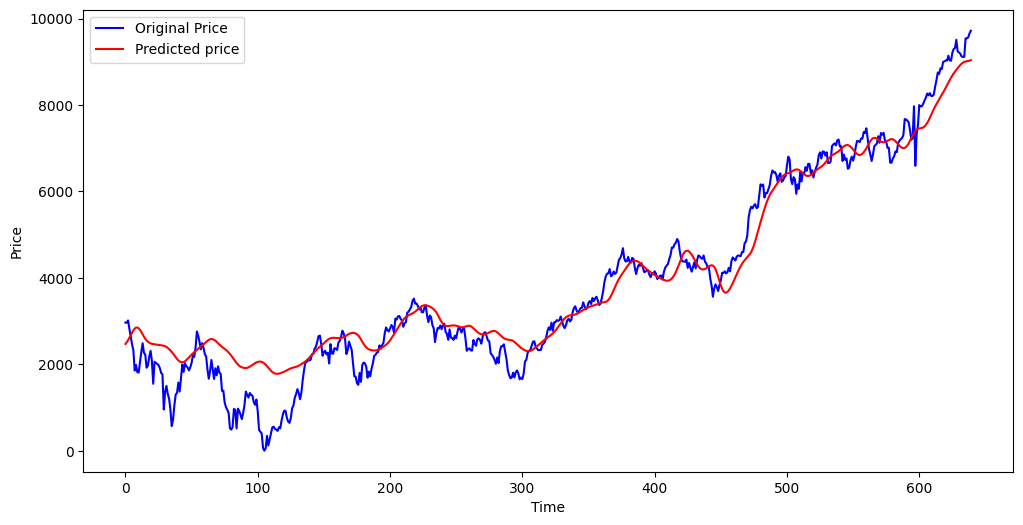

In [33]:
plt.figure(figsize=(12,6))
plt.plot(y_test , 'b' , label = 'Original Price')
plt.plot(y_predicted , 'r' , label = 'Predicted price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()